In [1]:
from keras.datasets import mnist
from keras import layers
from keras import models
from tensorflow import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import math   
import os
!pip install facenet_pytorch
import torchvision
import torch
import torch.nn as nn
import math
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFilter
from numpy.core.fromnumeric import argmax
from facenet_pytorch import MTCNN, extract_face
import cv2
from  matplotlib import pyplot as plt
from torch.autograd import Variable
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path ={
    # download training data from drive
    "train" : '../data/train/AFW',
    "model1" : '../data/models/mse-model.h5',
    "model2" : '../data/models/resnet.h5',
    "model3" : '../data/models/cross-entropy.h5',
    "test" : '../data/images/test_3.png',
    "test_group": '../data/images/group_3.png'
}

In [3]:
os_path = path['train']

In [4]:
list_of_names = os.listdir(os_path)
jpgs = []
for each in list_of_names:
  if(".jpg" in each):
    jpgs.append(each)
len(jpgs)

5543

In [5]:
train_jpgs, valid_jpgs_T= train_test_split(jpgs, test_size=0.2)
valid_jpgs, test_jpgs = train_test_split(valid_jpgs_T, test_size=0.5)
print(len(train_jpgs),len(valid_jpgs),len(test_jpgs))

4434 554 555


In [6]:
def get_pt2d_from_mat(mat_path):
    # Get 2D landmarks
    mat = loadmat(mat_path)
    pt2d = mat['pt2d']
    return pt2d

def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

In [7]:
labels = {}
for each in jpgs:
  xys = get_pt2d_from_mat(os_path+each[:-4])
  pose = get_ypr_from_mat(os_path+each[:-4])
  pitch, yaw, roll = pose[0] * 180 / np.pi, pose[1] * 180 / np.pi, pose[2] * 180 / np.pi
  bins = np.array(range(-99, 102, 3))
  binned_pose = np.digitize([yaw, pitch, roll], bins) - 1
  real_labels = np.float32(np.array([ yaw, pitch, roll]))
  labels[each] = (binned_pose,real_labels,xys)

In [8]:
train_y, valid_y, test_y = [], [], []
for each in train_jpgs:
  train_y.append(labels[each][0])
for each in valid_jpgs:
  valid_y.append(labels[each][0])
for each in test_jpgs:
  test_y.append(labels[each][0])
print(len(train_jpgs), len(train_y), len(valid_jpgs), len(valid_y), len(test_jpgs), len(test_y))

4434 4434 554 554 555 555


In [9]:
def loadImages(image_dataset_names):
    images = []
    for i, img_name in enumerate(image_dataset_names):
        img = cv2.imread(os_path+img_name)
        pt2d = labels[img_name][2]

        x_min = min(pt2d[0, :])
        y_min = min(pt2d[1, :])
        x_max = max(pt2d[0, :])
        y_max = max(pt2d[1, :])

        Lx = abs(x_max - x_min)
        Ly = abs(y_max - y_min)
        Lmax = max(Lx, Ly) * 1.5
        center_x = x_min + Lx // 2
        center_y = y_min + Ly // 2

        x_min = center_x - Lmax // 2
        x_max = center_x + Lmax // 2
        y_min = center_y - Lmax // 2
        y_max = center_y + Lmax // 2

        if x_min < 0:
            y_max -= abs(x_min)
            x_min = 0
        if y_min < 0:
            x_max -= abs(y_min)
            y_min = 0
        if x_max > img.shape[1]:
            y_min += abs(x_max - img.shape[1])
            x_max = img.shape[1]
        if y_max > img.shape[0]:
            x_min += abs(y_max - img.shape[0])
            y_max = img.shape[0]

        crop_img = img[int(y_min):int(y_max), int(x_min):int(x_max)]

        crop_img = np.asarray(cv2.resize(crop_img, (240,240)))
        normed_img = (crop_img - crop_img.mean()) / crop_img.std()
        images.append(normed_img)
    return images

train_images = loadImages(train_jpgs)
val_images = loadImages(valid_jpgs)

In [10]:
t0 = tf.keras.utils.to_categorical(np.array(train_y)[:,0],66)
t1 = tf.keras.utils.to_categorical(np.array(train_y)[:,1],66)
t2 = tf.keras.utils.to_categorical(np.array(train_y)[:,2],66)

v0 = tf.keras.utils.to_categorical(np.array(valid_y)[:,0],66)
v1 = tf.keras.utils.to_categorical(np.array(valid_y)[:,1],66)
v2 = tf.keras.utils.to_categorical(np.array(valid_y)[:,2],66)

In [11]:
final_train_y_yaw,final_train_y_pitch,final_train_y_roll = [], [], []
final_valid_y_yaw, final_valid_y_pitch, final_valid_y_roll = [], [], []
final_test_y_yaw, final_test_y_pitch, final_test_y_roll = [], [], []

for i, each in enumerate(train_jpgs):
  real_value = labels[each][1]
  bin_value = labels[each][0]
  final_train_y_yaw.append([real_value[0], bin_value[0]])
  final_train_y_pitch.append([real_value[1], bin_value[1]])
  final_train_y_roll.append([real_value[2], bin_value[2]])

for i, each in enumerate(valid_jpgs):
  real_value = labels[each][1]
  bin_value = labels[each][0]
  final_valid_y_yaw.append([real_value[0], bin_value[0]])
  final_valid_y_pitch.append([real_value[1], bin_value[1]])
  final_valid_y_roll.append([real_value[2], bin_value[2]])

for i, each in enumerate(test_jpgs):
  real_value = labels[each][1]
  bin_value = labels[each][0]
  final_test_y_yaw.append([real_value[0], bin_value[0]])
  final_test_y_pitch.append([real_value[1], bin_value[1]])
  final_test_y_roll.append([real_value[2], bin_value[2]])

final_train_y_yaw,final_train_y_pitch,final_train_y_roll = np.array(final_train_y_yaw),np.array(final_train_y_pitch),np.array(final_train_y_roll)
final_valid_y_yaw, final_valid_y_pitch, final_valid_y_roll = np.array(final_valid_y_yaw), np.array(final_valid_y_pitch), np.array(final_valid_y_roll)

In [ ]:
inputs = layers.Input(shape=(240, 240, 3))
feature = layers.Conv2D(filters=64, kernel_size=(11, 11), strides=4, padding='same', activation=tf.nn.relu)(inputs)
feature = layers.MaxPool2D(pool_size=(3, 3), strides=2)(feature)
feature = layers.Conv2D(filters=192, kernel_size=(5, 5), padding='same', activation=tf.nn.relu)(feature)
feature = layers.MaxPool2D(pool_size=(3, 3), strides=2)(feature)
feature = layers.BatchNormalization()(feature)
feature = layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(feature)
feature = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(feature)
feature = layers.BatchNormalization()(feature)
feature = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(feature)
feature = layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(feature)
feature = layers.MaxPool2D(pool_size=(3, 3), strides=2)(feature)
feature = layers.BatchNormalization()(feature)
feature = layers.Flatten()(feature)
feature = layers.Dropout(0.5)(feature)
feature = layers.Dense(units=4096, activation=tf.nn.relu)(feature)

fc_yaw = layers.Dense(name='yaw', units=66)(feature)
fc_pitch = layers.Dense(name='pitch', units=66)(feature)
fc_roll = layers.Dense(name='roll', units=66)(feature)
model3 = tf.keras.Model(inputs=inputs, outputs=[fc_yaw, fc_pitch, fc_roll])
idx_tensor = [idx for idx in range(66)]
idx_tensor = tf.Variable(np.array(idx_tensor, dtype=np.float32))
alpha=0.1

def loss_func(y_true, y_pred):
  real_true = y_true[:,0]
  bin_true = y_true[:,1]
  cat_f = tf.keras.losses.CategoricalCrossentropy(
  from_logits=True)
  bin_one_hot = tf.keras.utils.to_categorical(bin_true.numpy(),66)
  cls_loss = cat_f(bin_one_hot, y_pred)
  # MSE 
  pred_cont = tf.reduce_sum(tf.nn.softmax(y_pred) * idx_tensor, 1) * 3 - 99
  mse_loss = tf.losses.mean_squared_error(real_true, pred_cont)
  # Total loss
  total_loss = cls_loss + alpha * mse_loss
  return total_loss

def cat_accuracy(y_true, y_pred):
  bin_true = y_true[:,1]
  bin_one_hot = []
  y_pred_new = []
  for i,each in enumerate(bin_true):
    bin_one_hot.append(tf.keras.utils.to_categorical(each.numpy(),66))
    temp = np.zeros(66)
    temp[argmax([i])] = 1
    y_pred_new.append(temp)
  return accuracy_score(bin_one_hot, y_pred_new)

losses = {
  'yaw':loss_func,
  'pitch':loss_func,
  'roll':loss_func,
}
acc = {
  'yaw':cat_accuracy,
  'pitch':cat_accuracy,
  'roll':cat_accuracy,
}

model3.compile(optimizer='adam',loss=losses,loss_weights=[1, 0.3, 0.3],run_eagerly=True)

In [ ]:
history4 = model3.fit(np.array(train_images), [final_train_y_yaw,final_train_y_pitch,final_train_y_roll], epochs=50, batch_size=10, 
                      validation_data=(np.array(val_images), [final_valid_y_yaw, final_valid_y_pitch, final_valid_y_roll]))

Epoch 1/50
444/444 [==============================] - 47s 83ms/step - loss: 631.5141 - yaw_loss: 597.4269 - pitch_loss: 63.6473 - roll_loss: 49.9788 - val_loss: 1493.0464 - val_yaw_loss: 1385.1260 - val_pitch_loss: 230.6513 - val_roll_loss: 129.0840
Epoch 2/50
444/444 [==============================] - 39s 87ms/step - loss: 571.4311 - yaw_loss: 539.0206 - pitch_loss: 60.1386 - roll_loss: 47.8981 - val_loss: 453.2801 - val_yaw_loss: 421.1118 - val_pitch_loss: 65.6739 - val_roll_loss: 41.5539
Epoch 3/50
444/444 [==============================] - 37s 83ms/step - loss: 500.0024 - yaw_loss: 468.2897 - pitch_loss: 59.5643 - roll_loss: 46.1453 - val_loss: 437.5553 - val_yaw_loss: 406.2652 - val_pitch_loss: 60.6380 - val_roll_loss: 43.6628
Epoch 4/50
444/444 [==============================] - 38s 85ms/step - loss: 358.5547 - yaw_loss: 337.3401 - pitch_loss: 40.8828 - roll_loss: 29.8324 - val_loss: 344.1956 - val_yaw_loss: 321.8302 - val_pitch_loss: 46.7289 - val_roll_loss: 27.8222
Epoch 5/50
4

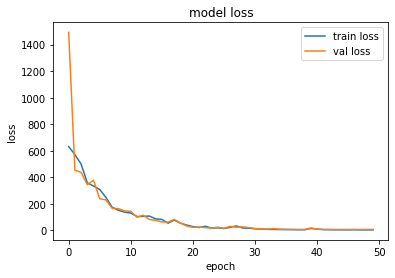

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.show()

In [ ]:
history4.history

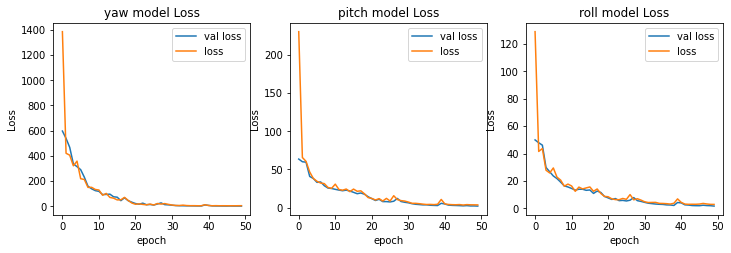

In [ ]:
grphs = ['yaw','pitch', 'roll']
def plot_loss_v_epoch_mul(model_history):
  plt.figure(figsize=(12,12))
  for i in range(3):
    ax=plt.subplot(3,3,i+1)
    plt.plot(model_history.history[grphs[i]+'_loss'])
    plt.plot(model_history.history['val_'+grphs[i]+'_loss'])
    plt.title(grphs[i]+' model Loss')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['val loss', 'loss'], loc='upper right')
  plt.show()
plot_loss_v_epoch_mul(history4)

In [ ]:
test_images = loadImages(test_jpgs[0:10])

In [ ]:
from math import cos, sin
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):

    pitch = pitch * np.pi / 180
    yaw = -(yaw * np.pi / 180)
    roll = roll * np.pi / 180

    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy
    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)
    return img

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


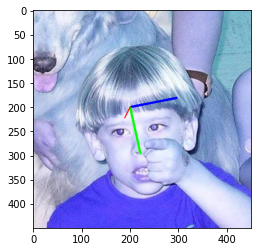

In [ ]:
%time
i=1
val =model3.predict(np.array([test_images[i]]))
predictions = np.asarray(val)
pred_cont_yaw = tf.reduce_sum(tf.nn.softmax(predictions[0,:,:]) * idx_tensor, 1) * 3 - 99
pred_cont_pitch = tf.reduce_sum(tf.nn.softmax(predictions[1,:,:]) * idx_tensor, 1) * 3 - 99
pred_cont_roll = tf.reduce_sum(tf.nn.softmax(predictions[2,:,:]) * idx_tensor, 1) * 3 - 99

cv2_img = cv2.imread(os_path+test_jpgs[i])
cv2_img = draw_axis(cv2_img, pred_cont_yaw[0], pred_cont_pitch[0], pred_cont_roll[0], tdx=200, tdy=200,
                    size=100)
plt.imshow(cv2_img)
cv2.imwrite("../data/outputs/"+str(test_jpgs[i]),cv2_img)

In [ ]:
test_images = loadImages(test_jpgs)
yaw_ground_truth, pitch_ground_truth, roll_ground_truth = [], [], []
for i, each in enumerate(test_jpgs):
  gt_yaw, gt_pitch, gt_roll = get_ypr_from_mat(os_path+test_jpgs[i][:-4])
  yaw_ground_truth.append(gt_yaw)
  pitch_ground_truth.append(gt_pitch)
  roll_ground_truth.append(gt_roll)
val =model3.predict(np.array(test_images))
predictions = np.asarray(val)

pred_cont_yaw = tf.reduce_sum(tf.nn.softmax(predictions[0,:,:]) * idx_tensor, 1) * 3 - 99
pred_cont_pitch = tf.reduce_sum(tf.nn.softmax(predictions[1,:,:]) * idx_tensor, 1) * 3 - 99
pred_cont_roll = tf.reduce_sum(tf.nn.softmax(predictions[2,:,:]) * idx_tensor, 1) * 3 - 99

from sklearn.metrics import mean_absolute_error as mae
mae_yaw = mae(pred_cont_yaw,yaw_ground_truth)
mae_pitch = mae(pred_cont_pitch,pitch_ground_truth)
mae_roll = mae(pred_cont_roll,roll_ground_truth)
print(mae_yaw)
print(mae_pitch)
print(mae_roll)
mae_c = (mae_yaw+mae_pitch+mae_roll)/3
print("MAE combined = ",mae_c)

49.08532128214418
10.826697878821816
8.032791612598823
MAE combined =  22.648270257854943


In [12]:
def residual_block(x,  filters: int, kernel_size: int = 3):
    y = layers.Conv2D(kernel_size=kernel_size,strides= (2),filters=filters, padding="same")(x)
    y = layers.ReLU()(y)
    y = layers.BatchNormalization()(y)
    y = layers.Conv2D(kernel_size=kernel_size,strides=1,filters=filters,padding="same")(y)
    x = layers.Conv2D(kernel_size=1,strides=2,filters=filters,padding="same")(x)
    out = layers.Add()([x, y])
    out = layers.ReLU()(out)
    out = layers.BatchNormalization()(out)
    return out

In [13]:
inputs = layers.Input(shape=(240, 240, 3))
feature = layers.Conv2D(filters=64, kernel_size=(11, 11), strides=4, padding='same', activation=tf.nn.relu)(inputs)
feature = layers.MaxPool2D(pool_size=(3, 3), strides=2)(feature)
feature = layers.BatchNormalization()(feature)
feature = layers.Conv2D(filters=192, kernel_size=(5, 5), padding='same', activation=tf.nn.relu)(feature)
feature = residual_block(feature, filters=192)
feature = layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(feature)
feature = layers.MaxPool2D(pool_size=(3, 3), strides=2)(feature)
feature = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(feature)
feature = residual_block(feature, filters=256)
feature = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(feature)
feature = layers.MaxPool2D(pool_size=(3, 3), strides=2)(feature)
feature = layers.BatchNormalization()(feature)
feature = layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(feature)
feature = layers.Dropout(0.3)(feature)
feature = residual_block(feature, filters=512)
feature = layers.AveragePooling2D(1)(feature)
feature = layers.Flatten()(feature)
feature = layers.BatchNormalization()(feature)
feature = layers.Dropout(0.4)(feature)
feature = layers.Dense(units=4096, activation=tf.nn.relu)(feature)


fc_yaw = layers.Dense(name='yaw', units=66)(feature)
fc_pitch = layers.Dense(name='pitch', units=66)(feature)
fc_roll = layers.Dense(name='roll', units=66)(feature)
model3 = tf.keras.Model(inputs=inputs, outputs=[fc_yaw, fc_pitch, fc_roll])
idx_tensor = [idx for idx in range(66)]
idx_tensor = tf.Variable(np.array(idx_tensor, dtype=np.float32))
alpha=0.1

def loss_func(y_true, y_pred):
  real_true = y_true[:,0]
  bin_true = y_true[:,1]
  cat_f = tf.keras.losses.CategoricalCrossentropy(
  from_logits=True)
  bin_one_hot = tf.keras.utils.to_categorical(bin_true.numpy(),66)
  cls_loss = cat_f(bin_one_hot, y_pred)
  # # MSE loss
  pred_cont = tf.reduce_sum(tf.nn.softmax(y_pred) * idx_tensor, 1) * 3 - 99
  mse_loss = tf.losses.mean_squared_error(real_true, pred_cont)
  # # Total loss
  total_loss = cls_loss + alpha * mse_loss
  return total_loss

losses = {
  'yaw':loss_func,
  'pitch':loss_func,
  'roll':loss_func,
}

model3.compile(optimizer='adam',loss=losses,loss_weights=[1, 0.3, 0.3],run_eagerly=True)

In [14]:
history5 = model3.fit(np.array(train_images), [final_train_y_yaw,final_train_y_pitch,final_train_y_roll], epochs=70, batch_size=10, 
                      validation_data=(np.array(val_images), [final_valid_y_yaw, final_valid_y_pitch, final_valid_y_roll]))

Epoch 1/70
444/444 [==============================] - 53s 94ms/step - loss: 308.4360 - yaw_loss: 294.6718 - pitch_loss: 26.0096 - roll_loss: 19.8712 - val_loss: 885.1490 - val_yaw_loss: 823.1561 - val_pitch_loss: 137.7129 - val_roll_loss: 68.9299
Epoch 2/70
444/444 [==============================] - 41s 93ms/step - loss: 434.4364 - yaw_loss: 417.2224 - pitch_loss: 33.3706 - roll_loss: 24.0100 - val_loss: 1057.7659 - val_yaw_loss: 1003.5449 - val_pitch_loss: 104.7016 - val_roll_loss: 76.0356
Epoch 3/70
444/444 [==============================] - 41s 92ms/step - loss: 389.6782 - yaw_loss: 370.8152 - pitch_loss: 37.4997 - roll_loss: 25.3767 - val_loss: 321.7328 - val_yaw_loss: 305.8390 - val_pitch_loss: 32.0054 - val_roll_loss: 20.9742
Epoch 4/70
444/444 [==============================] - 41s 92ms/step - loss: 312.1579 - yaw_loss: 296.0938 - pitch_loss: 30.9854 - roll_loss: 22.5608 - val_loss: 444.8510 - val_yaw_loss: 431.2681 - val_pitch_loss: 23.4373 - val_roll_loss: 21.8386
Epoch 5/70
4

In [15]:
test_images = loadImages(test_jpgs)
yaw_ground_truth, pitch_ground_truth, roll_ground_truth = [], [], []
for i, each in enumerate(test_jpgs):
  gt_yaw, gt_pitch, gt_roll = get_ypr_from_mat(os_path+test_jpgs[i][:-4])
  yaw_ground_truth.append(gt_yaw)
  pitch_ground_truth.append(gt_pitch)
  roll_ground_truth.append(gt_roll)
val =model3.predict(np.array(test_images))
predictions = np.asarray(val)
pred_cont_yaw = tf.reduce_sum(tf.nn.softmax(predictions[0,:,:]) * idx_tensor, 1) * 3 - 99
pred_cont_pitch = tf.reduce_sum(tf.nn.softmax(predictions[1,:,:]) * idx_tensor, 1) * 3 - 99
pred_cont_roll = tf.reduce_sum(tf.nn.softmax(predictions[2,:,:]) * idx_tensor, 1) * 3 - 99
from sklearn.metrics import mean_absolute_error as mae
mae_yaw = mae(pred_cont_yaw,yaw_ground_truth)
mae_pitch = mae(pred_cont_pitch,pitch_ground_truth)
mae_roll = mae(pred_cont_roll,roll_ground_truth)
print(mae_yaw)
print(mae_pitch)
print(mae_roll)
mae_c = (mae_yaw+mae_pitch+mae_roll)/3
print("MAE combined = ",mae_c)

48.713842232788686
8.791795370043305
4.734942312548166
MAE combined =  20.746859971793384


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf

In [ ]:
resnet50_imagenet_model = ResNet50(include_top=False, input_shape=(240, 240, 3))

feature = layers.Conv2D(filters=64, kernel_size=(11, 11), strides=4, padding='same', activation=tf.nn.relu)(resnet50_imagenet_model.output)
feature = layers.Conv2D(filters=192, kernel_size=(5, 5), padding='same', activation=tf.nn.relu)(feature)
feature = layers.BatchNormalization()(feature)
feature = layers.MaxPool2D(pool_size=(3, 3), strides=1, padding='same')(feature)
feature = layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(feature)
feature = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(feature)
feature = layers.BatchNormalization()(feature)
feature = layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=tf.nn.relu)(feature)
feature = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(feature)
feature = layers.BatchNormalization()(feature)
feature = layers.Flatten()(feature)
feature = layers.Dropout(0.5)(feature)
feature = layers.Dense(units=4096, activation=tf.nn.relu)(feature)

fc_yaw = layers.Dense(name='yaw', units=66)(feature)
fc_pitch = layers.Dense(name='pitch', units=66)(feature)
fc_roll = layers.Dense(name='roll', units=66)(feature)
model3 = tf.keras.Model(inputs=resnet50_imagenet_model.input, outputs=[fc_yaw, fc_pitch, fc_roll])
idx_tensor = [idx for idx in range(66)]
idx_tensor = tf.Variable(np.array(idx_tensor, dtype=np.float32))
alpha=0.1

def loss_func(y_true, y_pred):
  real_true = y_true[:,0]
  bin_true = y_true[:,1]
  cat_f = tf.keras.losses.CategoricalCrossentropy(
  from_logits=True)
  bin_one_hot = tf.keras.utils.to_categorical(bin_true.numpy(),66)
  cls_loss = cat_f(bin_one_hot, y_pred)
  #MSE 
  pred_cont = tf.reduce_sum(tf.nn.softmax(y_pred) * idx_tensor, 1) * 3 - 99
  mse_loss = tf.losses.mean_squared_error(real_true, pred_cont)
  #Total loss
  total_loss = cls_loss + alpha * mse_loss
  return total_loss

def cat_accuracy(y_true, y_pred):
  bin_true = y_true[:,1]
  bin_one_hot = []
  y_pred_new = []
  for i,each in enumerate(bin_true):
    bin_one_hot.append(tf.keras.utils.to_categorical(each.numpy(),66))
    temp = np.zeros(66)
    temp[argmax([i])] = 1
    y_pred_new.append(temp)
  return accuracy_score(bin_one_hot, y_pred_new)
losses = {
  'yaw':loss_func,
  'pitch':loss_func,
  'roll':loss_func,
}
acc = {
  'yaw':cat_accuracy,
  'pitch':cat_accuracy,
  'roll':cat_accuracy,
}

model3.compile(optimizer='adam',loss=losses,run_eagerly=True)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint("model1.h5", save_best_only=True)
history7 = model3.fit(np.array(train_images), [final_train_y_yaw,final_train_y_pitch,final_train_y_roll], epochs=70, batch_size=10, 
                      validation_data=(np.array(val_images), [final_valid_y_yaw, final_valid_y_pitch, final_valid_y_roll]),callbacks=[checkpoint])

Epoch 1/70
444/444 [==============================] - 138s 288ms/step - loss: 361.7982 - yaw_loss: 322.0495 - pitch_loss: 22.2034 - roll_loss: 17.5453 - val_loss: 363.0969 - val_yaw_loss: 326.3642 - val_pitch_loss: 19.9686 - val_roll_loss: 16.7641
Epoch 2/70
444/444 [==============================] - 124s 280ms/step - loss: 388.9721 - yaw_loss: 347.3214 - pitch_loss: 23.3468 - roll_loss: 18.3036 - val_loss: 2186.0815 - val_yaw_loss: 1852.6177 - val_pitch_loss: 199.1778 - val_roll_loss: 134.2860
Epoch 3/70
444/444 [==============================] - 125s 281ms/step - loss: 395.3845 - yaw_loss: 354.1647 - pitch_loss: 22.3024 - roll_loss: 18.9176 - val_loss: 367.6710 - val_yaw_loss: 330.4324 - val_pitch_loss: 20.1115 - val_roll_loss: 17.1271
Epoch 4/70
444/444 [==============================] - 126s 283ms/step - loss: 384.0934 - yaw_loss: 342.1123 - pitch_loss: 23.7977 - roll_loss: 18.1832 - val_loss: 482.6229 - val_yaw_loss: 406.5136 - val_pitch_loss: 44.9328 - val_roll_loss: 31.1765
Epoc

In [ ]:
test_images = loadImages(test_jpgs[0:10])

In [ ]:
test_images = loadImages(test_jpgs)
yaw_ground_truth, pitch_ground_truth, roll_ground_truth = [], [], []
for i, each in enumerate(test_jpgs):
  gt_yaw, gt_pitch, gt_roll = get_ypr_from_mat(os_path+test_jpgs[i][:-4])
  yaw_ground_truth.append(gt_yaw)
  pitch_ground_truth.append(gt_pitch)
  roll_ground_truth.append(gt_roll)
val =model3.predict(np.array(test_images))
predictions = np.asarray(val)
pred_cont_yaw = tf.reduce_sum(tf.nn.softmax(predictions[0,:,:]) * idx_tensor, 1) * 3 - 99
pred_cont_pitch = tf.reduce_sum(tf.nn.softmax(predictions[1,:,:]) * idx_tensor, 1) * 3 - 99
pred_cont_roll = tf.reduce_sum(tf.nn.softmax(predictions[2,:,:]) * idx_tensor, 1) * 3 - 99
from sklearn.metrics import mean_absolute_error as mae
mae_yaw = mae(pred_cont_yaw,yaw_ground_truth)
mae_pitch = mae(pred_cont_pitch,pitch_ground_truth)
mae_roll = mae(pred_cont_roll,roll_ground_truth)
print(mae_yaw)
print(mae_pitch)
print(mae_roll)
mae_c = (mae_yaw+mae_pitch+mae_roll)/3
print("MAE combined = ",mae_c)

49.291169982382726
11.073231510530363
8.034999715424279
MAE combined =  22.799800402779123


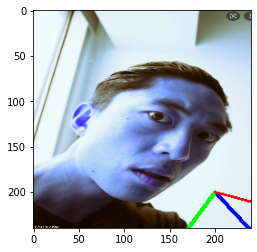

In [ ]:
from google.colab.patches import cv2_imshow
img = cv2.imread(path['test'])
img = cv2.resize(img,(240,240))
val =model3.predict(np.array([img]))
predictions = np.asarray(val)
pred_cont_yaw = tf.reduce_sum(tf.nn.softmax(predictions[0,:,:]) * idx_tensor, 1) * 3 - 99
pred_cont_pitch = tf.reduce_sum(tf.nn.softmax(predictions[1,:,:]) * idx_tensor, 1) * 3 - 99
pred_cont_roll = tf.reduce_sum(tf.nn.softmax(predictions[2,:,:]) * idx_tensor, 1) * 3 - 99
cv2_img = draw_axis(img, pred_cont_yaw[0], pred_cont_pitch[0], pred_cont_roll[0], tdx=100, tdy=100,size=100)
plt.imshow(cv2_img)

In [ ]:
def loss_function(y_true, y_pred):
  real_true = y_true[:,0]
  bin_true = y_true[:,1]
  cat_f = tf.keras.losses.CategoricalCrossentropy(
  from_logits=True)
  bin_one_hot = tf.keras.utils.to_categorical(bin_true.numpy(),66)
  cls_loss = cat_f(bin_one_hot, y_pred)
  # # MSE loss
  pred_cont = tf.reduce_sum(tf.nn.softmax(y_pred) * idx_tensor, 1) * 3 - 99
  mse_loss = tf.losses.mean_squared_error(real_true, pred_cont)
  # # Total loss
  total_loss = cls_loss + alpha * mse_loss
  return total_loss
loaded_model = model = keras.models.load_model(path['model1'],custom_objects={"loss_func": loss_function})

In [ ]:
from google.colab.patches import cv2_imshow

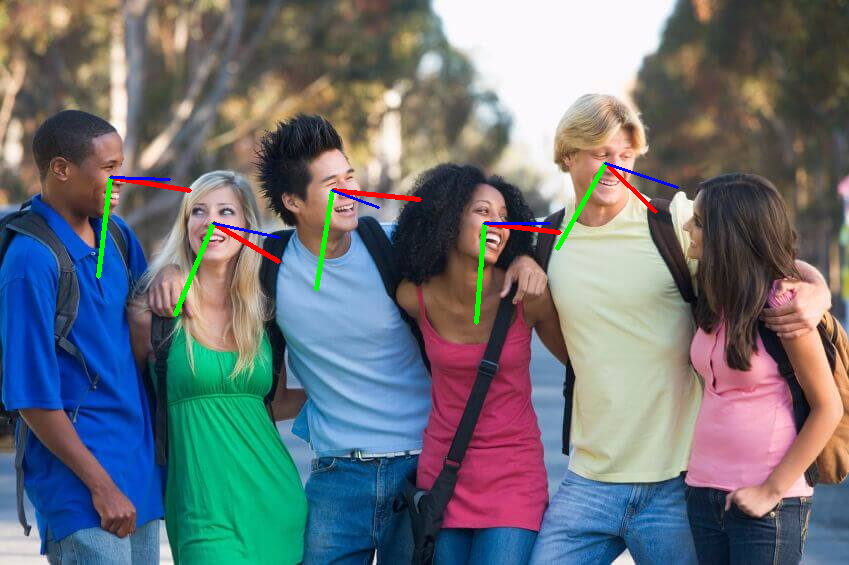

In [43]:
def test_model(model,img):
    mtcnn = MTCNN(keep_all=True, post_process=False,min_face_size = 10)
    boxes, probs, points = mtcnn.detect(img, landmarks=True)
    for i, box in enumerate(boxes):
        crop_img = extract_face(img, box, margin=50)
        crop_img = np.transpose(crop_img,(1,2,0))
        crop_img = crop_img.numpy()
        crop_img = np.array(Image.fromarray(np.uint8(crop_img)))
        crop_img = cv2.resize(crop_img,(240,240))
        val =model.predict(np.array([crop_img]))
        predictions = np.asarray(val)
        pred_cont_yaw = tf.reduce_sum(tf.nn.softmax(predictions[0,:,:]) * idx_tensor, 1) * 3 - 99
        pred_cont_pitch = tf.reduce_sum(tf.nn.softmax(predictions[1,:,:]) * idx_tensor, 1) * 3 - 99
        pred_cont_roll = tf.reduce_sum(tf.nn.softmax(predictions[2,:,:]) * idx_tensor, 1) * 3 - 99
        open_cv_image = np.array(Image.fromarray(np.uint8(img)))
        x = (box[0]+box[2])/2
        y = (box[1]+box[3])/2
        final_img = draw_axis(open_cv_image, pred_cont_yaw[0], pred_cont_pitch[0], pred_cont_roll[0],tdx = x,tdy=y)
        img = final_img
    cv2_imshow(img)
test_img = cv2.imread(path['test_group'])
test_model(loaded_model,test_img)